In [1]:
import pandas as pd
import numpy as np
import json
import time

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
df_labels= 'data/data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'data/dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
datapoint_zero = []
datapoint_one = []
start = time.time()
for datapoint in data_list[0:1000]:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                measurements = bag
    filtered_label = df_labels[(df_labels['transcript_id'] == specific_transcript_id) & 
                    (df_labels['transcript_position'] == specific_transcript_position)]['label']
    if len(filtered_label) != 1:
        print(f"Anomaly with {specific_transcript_id} at {specific_transcript_position} position, found {len(filtered_label)} matches")
    if filtered_label.iloc[0] == 0:
        datapoint_zero.append(measurements)
    else:
        datapoint_one.append(measurements)
print(f"process took {time.time() - start :2f}")

process took 3.632843


In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from collections import Counter
import pickle

clustered_data = []
counter = 0
for datapoint in data_list:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                counter += 1
                if counter %10000 == 0:
                    print(f"Batch of 10k done, at {counter}")
                data = np.array(bag)
                min_samples = 9

                ### Addition of reducing dimensionality to 3D ###
                split_data = data.reshape(-1, 3, 3)  # (x, 9) becomes (x, 3, 3)
                # Reshape to combine the first and second dimensions, resulting in a (3*x, 3) array
                split_data = split_data.reshape(-1, 3)
                data = split_data
                min_samples = 3 # Adjust min_samples to 3 for reducing dimensionality
                ### END OF addition ###

                k = 5
                nearest_neighbors = NearestNeighbors(n_neighbors=k)
                distances, _ = nearest_neighbors.fit(data).kneighbors(data)
                distances = np.sort(distances[:, k-1])

                # Find the elbow point for determining eps
                knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
                elbow_point = knee_locator.elbow
                recommended_eps = distances[elbow_point] if elbow_point else 0.5  # Default if no elbow is found

                # Perform DBSCAN clustering
                dbscan = DBSCAN(eps=recommended_eps, min_samples=min_samples) 
                labels = dbscan.fit_predict(data)
                unique_labels = set(labels) - {-1}  # Exclude noise

                # Initialize feature dictionary for this clustering instance
                features = {
                    'cluster_count_dbscan': len(unique_labels),
                    'silhoutte_score_dbscan': 0 if len(unique_labels) < 2 else silhouette_score(data, labels),
                    'noise_proportion_dbscan': list(labels).count(-1) / len(labels),
                    'mean_cluster_size_dbscan': np.mean([size for label, size in Counter(labels).items() if label != -1]) / len(data) if unique_labels else 0,
                    'transcript_id': specific_transcript_id,
                    'transcript_position': specific_transcript_position
                }

                clustered_data.append(features)

df_clustered_data = pd.DataFrame(clustered_data)
df_clustered_data.to_pickle("clustered_data_3d.pkl")

print("Clustering data saved as clustered_data_3d.pkl")


Batch of 10k done, at 10000
Batch of 10k done, at 20000
Batch of 10k done, at 30000
Batch of 10k done, at 40000
Batch of 10k done, at 50000
Batch of 10k done, at 60000
Batch of 10k done, at 70000
Batch of 10k done, at 80000
Batch of 10k done, at 90000
Batch of 10k done, at 100000
Batch of 10k done, at 110000
Batch of 10k done, at 120000
Clustering data saved as clustered_data_dbscan.pkl


In [4]:
sample_zero = datapoint_zero[0:50]
sample_one = datapoint_one[0:50]

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter


In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

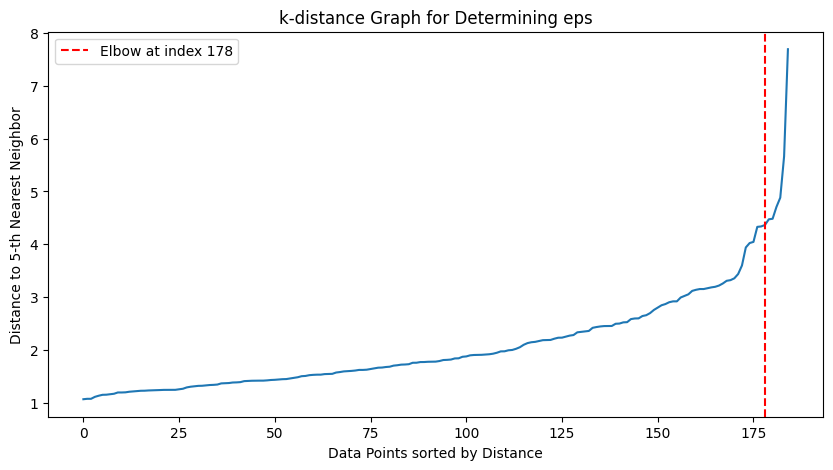

Recommended eps value: 4.364924927968407


In [84]:
data = sample_zero[2]

# Set k for k-nearest neighbors (4 or 5 is a common choice)
k = 5
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data)
distances, indices = neighbors.kneighbors(data)

# Sort the k-distance for each point to get a k-distance graph
distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

# Find the elbow point
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
elbow_point = knee_locator.elbow

# Plotting the k-distance graph to find the "elbow"
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow at index {elbow_point}')
plt.xlabel("Data Points sorted by Distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.title("k-distance Graph for Determining eps")
plt.legend()
plt.show()

# Recommended eps value based on the elbow point
recommended_eps = distances[elbow_point]
print("Recommended eps value:", recommended_eps)

In [13]:
data = sample_zero[4]

for idx, data in enumerate(sample_zero):
    data = np.array(data)
    split_data = data.reshape(-1, 3, 3)  # (x, 9) becomes (x, 3, 3)
    # Reshape to combine the first and second dimensions, resulting in a (3*x, 3) array
    split_data = split_data.reshape(-1, 3)
    data = split_data
    # Set k for k-nearest neighbors (4 or 5 is a common choice)
    k = 5
    features = {}
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)

    # Sort the k-distance for each point to get a k-distance graph
    distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

    # Find the elbow point
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_point = knee_locator.elbow
    # Recommended eps value based on the elbow point
    recommended_eps = distances[elbow_point]

    eps = recommended_eps  # Example value; tune based on data
    min_samples = 3  # Example value; tune based on data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    clusters = dbscan.fit(data).labels_

    cluster_counts = Counter(labels)
    if len(cluster_counts) == 1:
        score = 0
    else:
        score = silhouette_score(data, clusters)
    print("Cluster sizes (including noise):", cluster_counts, score)
    features['cluster_count'] = len(set(labels) - {-1})

    # 3. Noise Proportion
    features['noise_proportion'] = list(labels).count(-1) / len(labels)

    # 4. Mean Cluster Size and 5. Variance in Cluster Sizes
    cluster_sizes = [size for label, size in Counter(labels).items() if label != -1]
    features['mean_cluster_size'] = np.mean(cluster_sizes)/len(data)

    for k, v in features.items():
        print(k, v)

    # Dimensionality reduction for visualization (using t-SNE)
    # tsne = TSNE(n_components=2, random_state=42)
    # data_2d = tsne.fit_transform(data)

    # # Plotting the clusters
    # plt.figure(figsize=(10, 7))
    # unique_labels = set(labels)
    # for label in unique_labels:
    #     if label == -1:
    #         # Noise points
    #         color = 'gray'
    #         marker = 'x'
    #     else:
    #         color = plt.cm.jet(float(label) / (len(unique_labels) - 1))
    #         marker = 'o'
    #     plt.scatter(data_2d[labels == label, 0], data_2d[labels == label, 1],
    #                 label=f'Cluster {label}' if label != -1 else 'Noise',
    #                 c=[color], marker=marker, edgecolor='k', s=50)

    # plt.title('DBSCAN Clustering with t-SNE Visualization')
    # plt.xlabel('t-SNE Component 1')
    # plt.ylabel('t-SNE Component 2')
    # plt.legend()
    # plt.show()

Cluster sizes (including noise): Counter({0: 356, 1: 184, 2: 10, -1: 5}) 0.7541259221364313
cluster_count 3
noise_proportion 0.009009009009009009
mean_cluster_size 0.3303303303303303
Cluster sizes (including noise): Counter({0: 496, -1: 20}) 0.22933230782404776
cluster_count 1
noise_proportion 0.03875968992248062
mean_cluster_size 0.9612403100775194
Cluster sizes (including noise): Counter({0: 539, -1: 12, 1: 4}) -0.19654565946262964
cluster_count 2
noise_proportion 0.021621621621621623
mean_cluster_size 0.4891891891891892
Cluster sizes (including noise): Counter({1: 394, 0: 189, -1: 17}) 0.742284904971307
cluster_count 2
noise_proportion 0.028333333333333332
mean_cluster_size 0.48583333333333334
Cluster sizes (including noise): Counter({0: 392, 1: 197, -1: 5}) 0.8217983900223044
cluster_count 2
noise_proportion 0.008417508417508417
mean_cluster_size 0.4957912457912458
Cluster sizes (including noise): Counter({2: 378, 0: 192, 1: 5, -1: 1}) 0.5641836131289016
cluster_count 3
noise_propo

In [14]:
data = sample_zero[4]

for idx, data in enumerate(sample_one):
    data = np.array(data)
    split_data = data.reshape(-1, 3, 3)  # (x, 9) becomes (x, 3, 3)
    # Reshape to combine the first and second dimensions, resulting in a (3*x, 3) array
    split_data = split_data.reshape(-1, 3)
    data = split_data
    # Set k for k-nearest neighbors (4 or 5 is a common choice)
    k = 5
    features = {}
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)

    # Sort the k-distance for each point to get a k-distance graph
    distances = np.sort(distances[:, k-1])  # k-1 because we want the k-th nearest distance

    # Find the elbow point
    knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    elbow_point = knee_locator.elbow
    # Recommended eps value based on the elbow point
    recommended_eps = distances[elbow_point]

    eps = recommended_eps  # Example value; tune based on data
    min_samples = 3  # Example value; tune based on data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    clusters = dbscan.fit(data).labels_

    cluster_counts = Counter(labels)
    if len(cluster_counts) == 1:
        score = 0
    else:
        score = silhouette_score(data, clusters)
    print("Cluster sizes (including noise):", cluster_counts, score)
    features['cluster_count'] = len(set(labels) - {-1})

    # 3. Noise Proportion
    features['noise_proportion'] = list(labels).count(-1) / len(labels)

    # 4. Mean Cluster Size and 5. Variance in Cluster Sizes
    cluster_sizes = [size for label, size in Counter(labels).items() if label != -1]
    features['mean_cluster_size'] = np.mean(cluster_sizes)/len(data)

    for k, v in features.items():
        print(k, v)

Cluster sizes (including noise): Counter({0: 349, 1: 173, -1: 15}) 0.7337503282170992
cluster_count 2
noise_proportion 0.027932960893854747
mean_cluster_size 0.4860335195530726
Cluster sizes (including noise): Counter({0: 117, 1: 60, -1: 3}) 0.628749681474954
cluster_count 2
noise_proportion 0.016666666666666666
mean_cluster_size 0.49166666666666664
Cluster sizes (including noise): Counter({1: 109, 0: 51, -1: 11}) 0.6264163037999281
cluster_count 2
noise_proportion 0.06432748538011696
mean_cluster_size 0.4678362573099415
Cluster sizes (including noise): Counter({0: 74, 2: 44, 1: 11, -1: 3}) 0.5973218851435071
cluster_count 3
noise_proportion 0.022727272727272728
mean_cluster_size 0.32575757575757575
Cluster sizes (including noise): Counter({0: 88, 1: 46, 2: 5, -1: 5}) 0.42921236399395457
cluster_count 3
noise_proportion 0.034722222222222224
mean_cluster_size 0.3217592592592593
Cluster sizes (including noise): Counter({0: 104, 1: 52}) 0.8117707269848484
cluster_count 2
noise_proportion 